In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, jaccard_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('prepped_data.csv')

In [3]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.sample(4)

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn,...,Contract_enc,Tech_enc,Churn_enc,int_serv_enc,Age_group,CustPaymentCat,Tenure_cat,Tenure_cat_enc,CustPaymentCat_enc,Age_group_enc
912,913,47,Male,11,37.74,Two-Year,Fiber Optic,415.14,Yes,Yes,...,2,1,1,1,mid-age,low,<1yr,1,1,2
642,643,42,Female,60,45.38,One-Year,DSL,2722.80,Yes,No,...,1,1,0,0,mid-age,low,>4yr,3,1,2
748,749,38,Female,26,67.01,One-Year,Missing,1742.26,No,Yes,...,1,0,1,2,adult,medium,2-4yr,0,2,0
318,319,48,Male,7,63.07,Month-to-Month,Fiber Optic,441.49,Yes,Yes,...,0,1,1,1,mid-age,medium,<1yr,1,2,2


In [4]:
features = ['Gender_enc', 'Contract_enc', 'int_serv_enc', 'Tenure', 'MonthlyCharges', 'Age_group_enc', 'Tech_enc']

X = df[features]
Y = df['Churn_enc']

scale = MinMaxScaler()

def standard(X):
    X['Tenure'] = scale.fit_transform(X[['Tenure']])
    X['MonthlyCharges'] = scale.fit_transform(X[['MonthlyCharges']])
    return X

In [5]:
X.head()

,Gender_enc,Contract_enc,int_serv_enc,Tenure,MonthlyCharges,Age_group_enc,Tech_enc
0,1,0,1,4,88.35,2,1
1,1,0,1,0,36.67,2,1
2,0,0,1,2,63.79,4,0
3,0,1,0,8,102.34,3,1
4,1,0,2,32,69.01,2,0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_matrix(y_test, y_pred):
    
    cm = confusion_matrix(y_test, y_pred)
    
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel('Pred')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(['not-churn', 'churn'])
    ax.yaxis.set_ticklabels(['not-churn', 'churn'])
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_s, y_train_s = smote.fit_resample(x_train, y_train)

In [9]:
x_train = standard(x_train)
x_test = standard(x_test)

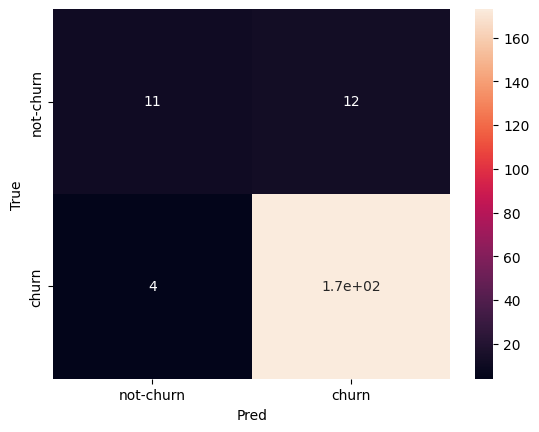

In [10]:
lr = LogisticRegression()

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

plot_matrix(y_test, y_pred)

In [11]:
from sklearn.metrics import recall_score

log_recall = recall_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred)
log_f1 = f1_score(y_test, y_pred)
log_recall, log_acc, log_f1

(0.9774011299435028, 0.92, 0.9558011049723757)

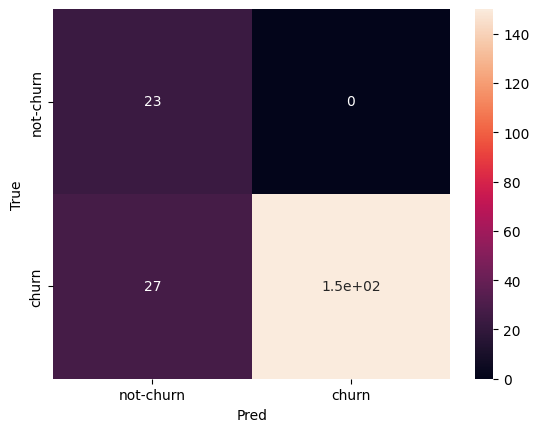

In [13]:
svc = SVC(class_weight='balanced')

svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)

plot_matrix(y_test, y_pred)

In [14]:
svc_recall = recall_score(y_test, y_pred)
svc_acc = accuracy_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred)

svc_recall, svc_acc, svc_f1

(0.847457627118644, 0.865, 0.9174311926605505)

In [15]:
params = {
    'C': [0.1, 1, 10, 100],
    'kernel':['linear', 'rbf', 'poly'],
    'gamma':['scale', 'auto', 0.1, 1]
}

svc_grid = GridSearchCV(
    estimator=svc,
    param_grid=params,
    scoring='recall',
    cv=5,
    verbose=1
)

svc_grid.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='recall', verbose=1)

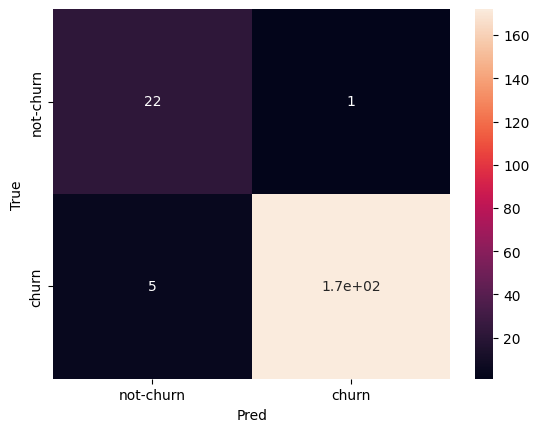

In [16]:
best_svc = svc_grid.best_estimator_
y_pred = best_svc.predict(x_test)

plot_matrix(y_test, y_pred)

In [17]:
svc_recall = recall_score(y_test, y_pred)
svc_acc = accuracy_score(y_test, y_pred)
svc_f1 = f1_score(y_test, y_pred)

svc_recall, svc_acc, svc_f1

(0.9717514124293786, 0.97, 0.9828571428571429)

In [18]:
svc_grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'poly'}

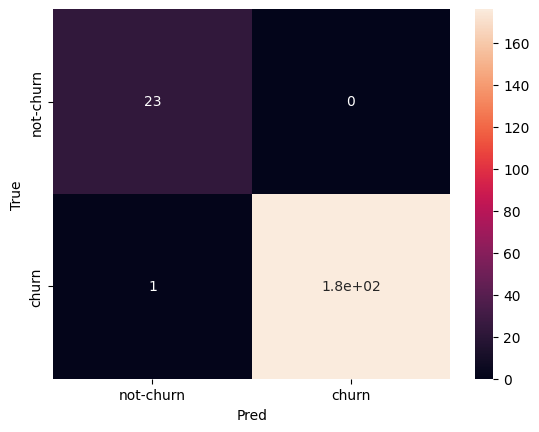

In [20]:
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

plot_matrix(y_test, y_pred)

In [21]:
rf_recall = recall_score(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

rf_recall, rf_acc, rf_f1

(0.9943502824858758, 0.995, 0.9971671388101983)

In [23]:
importances = rf.feature_importances_

imp_df = pd.DataFrame({
    'features':X.columns,
    'importance': importances
})

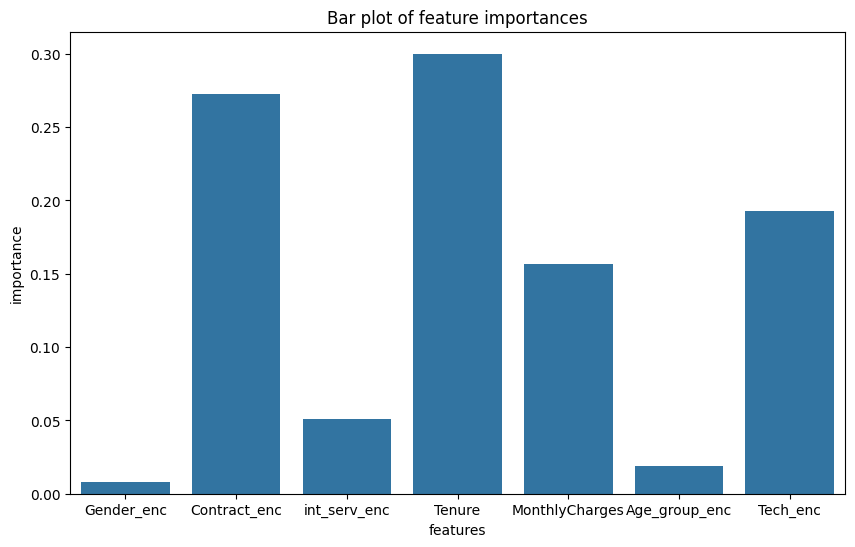

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(y = 'importance', x='features', data = imp_df)
plt.title('Bar plot of feature importances')
plt.show()

This indicates that the Tenure, Contract type, Use of tech Support and Monthly charges are the most deciding factors in customer churn

<h2>CLUSTER ANALYSIS</h2>

Customer segmentation to better Identify customers to focus retention strategies

In [33]:
from sklearn.cluster import KMeans

featuers = ['Contract_enc', 'int_serv_enc', 'Tenure', 'MonthlyCharges', 'Tech_enc']

X = X[features]

inertia = []
K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

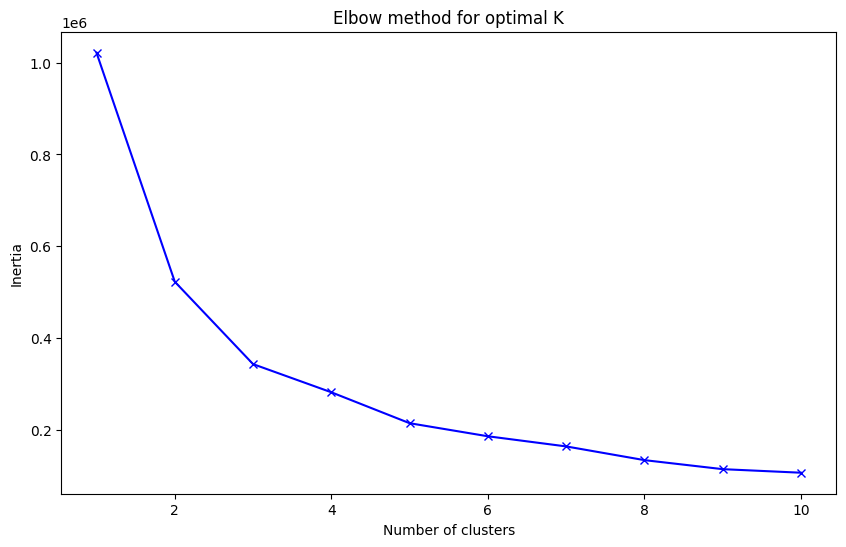

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal K')
plt.show()

This indicates 3 as our optimal number of clusters

In [35]:
opt_k = 3

km = KMeans(n_clusters=opt_k, random_state=42)

df['Cluster'] = km.fit_predict(X)

In [37]:
df.groupby('Cluster').mean(numeric_only=True)

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Gender_enc,Contract_enc,Tech_enc,Churn_enc,int_serv_enc,Tenure_cat_enc,CustPaymentCat_enc,Age_group_enc
Cluster,,,,,,,,,,,,,
0,499.284091,44.343182,13.934091,51.582114,700.735750,0.440909,0.734091,0.513636,0.852273,0.956818,1.090909,1.529545,2.195455
1,501.532110,44.972477,12.860092,97.362018,1274.681858,0.477064,0.642202,0.504587,0.947248,1.018349,1.098624,0.151376,2.261468
2,501.185484,44.798387,58.346774,74.559032,4357.089032,0.483871,0.693548,0.483871,0.766129,1.000000,2.056452,1.040323,2.282258


**Suggested Strategies:**

- Cluster 0: These are high-risk, low-revenue customers. Focus on retention tactics, including personalized promotions, onboarding, and customer support improvements.
- Cluster 1: These high-revenue customers are at high risk. Consider contract incentives, premium service offers, and improving customer service to prevent churn.
- Cluster 2: Long-term, loyal customers with moderate risk. Retain these with loyalty programs and proactive engagement.